## Homework 4
### Text Classification with CNN

Welcome to Homework 4! 

The homework contains several tasks. You can find the amount of points that you get for the correct solution in the task header. Maximum amount of points for each homework is _four_.

The **grading** for each task is the following:
- correct answer - **full points**
- insufficient solution or solution resulting in the incorrect output - **half points**
- no answer or completely wrong solution - **no points**

Even if you don't know how to solve the task, we encourage you to write down your thoughts and progress and try to address the issues that stop you from completing the task.

When working on the written tasks, try to make your answers short and accurate. Most of the times, it is possible to answer the question in 1-3 sentences.

When writing code, make it readable. Choose appropriate names for your variables (`a = 'cat'` - not good, `word = 'cat'` - good). Avoid constructing lines of code longer than 100 characters (79 characters is ideal). If needed, provide the commentaries for your code, however, a good code should be easily readable without them :)

Finally, all your answers should be written only by yourself. If you copy them from other sources it will be considered as an academic fraud. You can discuss the tasks with your classmates but each solution must be individual.

<font color='red'>**Important!:**</font> **before sending your solution, do the `Kernel -> Restart & Run All` to ensure that all your code works.**

In [3]:
!pip install datasets torchmetrics --quiet

     |████████████████████████████████| 312 kB 5.1 MB/s 
     |████████████████████████████████| 397 kB 45.1 MB/s 
     |████████████████████████████████| 134 kB 36.2 MB/s 
     |████████████████████████████████| 212 kB 38.2 MB/s 
     |████████████████████████████████| 67 kB 4.2 MB/s 
     |████████████████████████████████| 1.1 MB 16.1 MB/s 
     |████████████████████████████████| 127 kB 40.1 MB/s 
     |████████████████████████████████| 94 kB 1.8 MB/s 
     |████████████████████████████████| 271 kB 12.5 MB/s 
     |████████████████████████████████| 144 kB 39.0 MB/s 
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
datascience 0.10.6 requires folium==0.2.1, but you have folium 0.8.3 which is incompatible.


In [4]:
import torch
import torch.nn as nn
from datasets import load_dataset
from torch.utils.data import Dataset, DataLoader
from torchmetrics.functional import f1_score, accuracy
import json
from tqdm.notebook import tqdm

In this homework, you are going to work again with [Stanford Semantic Treebank](https://nlp.stanford.edu/sentiment/index.html).

Only this time, we are going to split the labels into five classes, instead of two. This way, we will do a multi-class classification.

Run the cell below to load the dataset.

In [5]:
sst = load_dataset("sst", "default")

Downloading:   0%|          | 0.00/2.59k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.17k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/6.37M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/790k [00:00<?, ?B/s]

0 examples [00:00, ? examples/s]

0 examples [00:00, ? examples/s]

0 examples [00:00, ? examples/s]

Dataset sst downloaded and prepared to /root/.cache/huggingface/datasets/sst/default/1.0.0/b8a7889ef01c5d3ae8c379b84cc4080f8aad3ac2bc538701cbe0ac6416fb76ff. Subsequent calls will reuse this data.


  0%|          | 0/3 [00:00<?, ?it/s]

Download the pretrained [GloVe 6B](https://nlp.stanford.edu/projects/glove/) word embeddings. 

If you are on Windows, just copy the URL into your browser, download the ZIP file and unpack it into the same folder as this notebook.

In [6]:
!wget https://nlp.stanford.edu/data/glove.6B.zip
!unzip glove.6B.zip

--2022-03-08 06:02:59--  https://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2022-03-08 06:02:59--  http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glove.6B.zip        100%[===================>] 822.24M  5.06MB/s    in 2m 40s  

2022-03-08 06:05:39 (5.14 MB/s) - ‘glove.6B.zip’ saved [862182613/862182613]

Archive:  glove.6B.zip
  inflating: glove.6B.50d.txt        
  inflating: glove.6B.100d.txt       
  inflating: 

In [7]:
# Load the embeddings into the memory
glove_path = 'glove.6B.300d.txt'
glove_vecs = []
idx2token = []
with open(glove_path, encoding='utf-8') as f:
    for line in tqdm(f):
        line = line.strip().split()
        word = line[0]
        vec = [float(x) for x in line[1:]]
        glove_vecs.append(vec)
        idx2token.append(word)

# Convert to tensor
glove_vecs = torch.tensor(glove_vecs)

# Put zero vector for padding and mean for unknown
glove_vecs = torch.vstack(
    [
        torch.zeros(1, glove_vecs.size(1)),
        torch.mean(glove_vecs, dim=0).unsqueeze(0),
        glove_vecs,
    ]
)

# Save the embeddings in Pytorch format
torch.save(glove_vecs, 'glove.6B.300d.pt')

# Add special pad and unk tokens to the vocab
PAD = '<pad>'
PAD_ID = 0
UNK = '<unk>'
UNK_ID = 1

idx2token = [PAD, UNK] + idx2token

# Save the vocab
json.dump(idx2token, open('idx2token.json', 'w', encoding='utf-8'))

0it [00:00, ?it/s]

Uncomment the cell below if you want to load the saved embeddings and vocabulary

In [8]:
# PAD = '<pad>'
# PAD_ID = 0
# UNK = '<unk>'
# UNK_ID = 1

# glove_vecs = torch.load('glove.6B.300d.pt')
# idx2token = json.load(open('idx2token.json', encoding='utf-8'))

In [9]:
# Create a reverse vocab
token2idx = {token: idx for idx, token in enumerate(idx2token)}

In [10]:
# Set the device (GPU or CPU)
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
device

device(type='cuda')

### Task 1. Build the dataset (1 point)

The SST dataset has a sentiment label for each sentence. This label ranges from 0 to 1, 0 being very negative and 1 being very positive. During the practice session, we split the labels into a binary format, i.e. all the labels lower than 0.5 became 0 and greater than 0.5 became 1.

This time, you will need to split them into five categories that have the following ranges: $(0, 0.2]$, $(0.2, 0.4]$, $(0.4, 0.6]$, $(0.6, 0.8]$, $(0.8, 1]$. They should be transformed into the labels $0$, $1$, $2$, $3$, $4$ respectively.

In the end, you should have five labels:
- 0 (very negative)
- 1 (negative)
- 2 (neural)
- 3 (positive)
- 4 (very positive)

In [11]:
class SSTDataset(Dataset):
    def __init__(self, data, token2idx, max_seq_len=100, device=torch.device('cpu')):
        super().__init__()
        self.max_seq_len = max_seq_len
        self.device = device

        self.texts = []
        self.labels = []
        for item in data:
            label = item['label']
            tokens = [token2idx.get(token.lower(), UNK_ID) for token in item['tokens'].split('|')]
            tokens = torch.tensor(tokens, dtype=torch.long, device=self.device)
            self.texts.append(tokens)

            # Transform the continuous label into five classes and add it to the self.labels list
            ### YOUR CODE STARTS HERE
            breakpoints=[0,0.2,0.4,0.6,0.8]
            from bisect import bisect
            self.labels.append(bisect(breakpoints,label)-1)
            ### YOUR CODE ENDS HERE

    def __getitem__(self, idx):
        padded_text = torch.zeros(self.max_seq_len, dtype=torch.long, device=self.device)
        text = self.texts[idx][:self.max_seq_len]
        padded_text[:text.size(0)] = text
        return padded_text, self.labels[idx]

    def __len__(self):
        return len(self.texts)

Load the datasets.

In [12]:
train_dataset = SSTDataset(sst['train'], token2idx, max_seq_len=52, device=device)
validation_dataset = SSTDataset(sst['validation'], token2idx, max_seq_len=52, device=device)
test_dataset = SSTDataset(sst['test'], token2idx, max_seq_len=52, device=device)

In [13]:
len(train_dataset), len(validation_dataset), len(test_dataset)

(8544, 1101, 2210)

In [14]:
train_dataloader = DataLoader(train_dataset, batch_size=50)
validation_dataloader = DataLoader(validation_dataset, batch_size=50)
test_dataloader = DataLoader(test_dataset, batch_size=50)

### Task 2. Modify the Model (1 point)

Since now we have five classes instead of two, you need to modify the final layer of the model to have five outputs (ref. [nn.Linear](https://pytorch.org/docs/stable/generated/torch.nn.Linear.html?highlight=linear#torch.nn.Linear)).

Also, we are going to finetune the pretrained embeddings this time, so you need to "unfreeze" them (ref. [nn.Embedding](https://pytorch.org/docs/stable/generated/torch.nn.Embedding.html?highlight=embedding#torch.nn.Embedding)).

This task doesn't have `### YOUR CODE STARTS HERE` field, you have to find the parameters and modify them yourself.

In [15]:
class SSTClassificationModel(nn.Module):
    def __init__(self, pretrained_emb, num_filters, kernel_sizes):
        super().__init__()
        self.emb = nn.Embedding.from_pretrained(pretrained_emb, padding_idx=PAD_ID, freeze=False)
        emb_size = self.emb.weight.size(1)

        self.convs = nn.ModuleList(
            [
                  nn.Conv1d(in_channels=emb_size, out_channels=num_filters, kernel_size=kernel_size)
                  for kernel_size in kernel_sizes                  
            ]
        )
        self.linear_out = nn.Linear(in_features=num_filters * len(kernel_sizes), out_features=5)
        self.drop = nn.Dropout(0.5)

    def forward(self, x):
        # x size is [batch x seq_len]
        x = self.emb(x) # [batch x seq_len x emb_dim]
        x = x.permute(0, 2, 1) # [batch x emb_dim x seq_len]
        xs = [torch.relu(conv(x)) for conv in self.convs] # [batch x num_filters x conv_seq_len] x num_kernels
        xs = [torch.nn.functional.max_pool1d(x, x.size(2)).squeeze(2) for x in xs] # [batch x num_filters] x num_kernels
        x = torch.cat(xs, dim=1) # [batch x num_filters * num_kernels]
        x = self.drop(x)
        x = self.linear_out(x) # [batch x 2]
        return x

Model parameters. Feel free to modify them if you'd like to.

In [16]:
num_filters = 100
kernel_sizes = [3, 4, 5]
lr = 1e-3

num_iters = 100

Initalize the model.

In [17]:
model = SSTClassificationModel(glove_vecs, num_filters, kernel_sizes)
model = model.to(device)

In [18]:
print(model)

SSTClassificationModel(
  (emb): Embedding(400002, 300, padding_idx=0)
  (convs): ModuleList(
    (0): Conv1d(300, 100, kernel_size=(3,), stride=(1,))
    (1): Conv1d(300, 100, kernel_size=(4,), stride=(1,))
    (2): Conv1d(300, 100, kernel_size=(5,), stride=(1,))
  )
  (linear_out): Linear(in_features=300, out_features=5, bias=True)
  (drop): Dropout(p=0.5, inplace=False)
)


Initialize the loss and optimizer. Feel free to use different optimizer if you'd like to.

In [19]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

Train the model.

__This may take around 25-30 minutes!__

In the end, you should have around 0.40 accuracy.
If the training takes too long or you have time constrains, feel free to reduce the number of epochs.

In [20]:
best_accuracy = 0.0
for i in range(num_iters):
    current_loss = 0
    model.train()
    for texts, labels in train_dataloader:
        model.zero_grad()
        preds = model(texts)
        labels=torch.tensor(labels).long().to(device)
        loss = loss_fn(preds, labels)
        current_loss += loss
        loss.backward()
        optimizer.step()
    avg_train_loss = current_loss.item() / len(train_dataloader)

    current_loss = 0
    current_acc = 0
    model.eval()
    for texts, labels in validation_dataloader:
        with torch.no_grad():
            preds = model(texts)
            labels=torch.tensor(labels).long().to(device)
            loss = loss_fn(preds, labels)
            preds = torch.argmax(torch.log_softmax(preds, dim=1), dim=1)
            acc = accuracy(preds, labels)
            current_loss += loss
            current_acc += acc
    avg_val_loss = current_loss.item() / len(validation_dataloader)
    avg_val_acc = current_acc.item() / len(validation_dataloader)

    if avg_val_acc > best_accuracy:
        print(f'Accuracy increased [{best_accuracy:.4f} --> {avg_val_acc:.4f}]. Saving the model...')
        best_accuracy = avg_val_acc
        torch.save(model, 'model_best.pt')

    print(f'Epoch: {i}\tTrain loss: {avg_train_loss:.4f}\tVal loss: {avg_val_loss:.4f}\tVal acc: {avg_val_acc:.4f}')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Accuracy increased [0.0000 --> 0.2974]. Saving the model...
Epoch: 0	Train loss: 1.2682	Val loss: 1.7318	Val acc: 0.2974
Epoch: 1	Train loss: 1.2806	Val loss: 1.7097	Val acc: 0.2496
Epoch: 2	Train loss: 1.1406	Val loss: 1.6654	Val acc: 0.2687
Accuracy increased [0.2974 --> 0.3113]. Saving the model...
Epoch: 3	Train loss: 0.9019	Val loss: 1.7026	Val acc: 0.3113
Accuracy increased [0.3113 --> 0.3365]. Saving the model...
Epoch: 4	Train loss: 0.6330	Val loss: 1.7822	Val acc: 0.3365
Accuracy increased [0.3365 --> 0.3391]. Saving the model...
Epoch: 5	Train loss: 0.4080	Val loss: 2.0280	Val acc: 0.3391
Accuracy increased [0.3391 --> 0.3696]. Saving the model...
Epoch: 6	Train loss: 0.2690	Val loss: 2.4153	Val acc: 0.3696
Accuracy increased [0.3696 --> 0.3739]. Saving the model...
Epoch: 7	Train loss: 0.1948	Val loss: 2.6628	Val acc: 0.3739
Epoch: 8	Train loss: 0.1462	Val loss: 2.7479	Val acc: 0.3739
Epoch: 9	Train loss: 0.1129	Val loss: 3.0582	Val acc: 0.3678
Epoch: 10	Train loss: 0.0886	V

Load the best model.

In [21]:
model = torch.load('model_best.pt')

In [22]:
model.to(device)

SSTClassificationModel(
  (emb): Embedding(400002, 300, padding_idx=0)
  (convs): ModuleList(
    (0): Conv1d(300, 100, kernel_size=(3,), stride=(1,))
    (1): Conv1d(300, 100, kernel_size=(4,), stride=(1,))
    (2): Conv1d(300, 100, kernel_size=(5,), stride=(1,))
  )
  (linear_out): Linear(in_features=300, out_features=5, bias=True)
  (drop): Dropout(p=0.5, inplace=False)
)

Test the model on the test set and save all the labels and predictions.

In [23]:
current_acc = 0
current_loss = 0
y_true = []
y_pred = []
model.eval()
with torch.no_grad():
    for text, label in test_dataloader:
        label = torch.tensor(label).long().to(device)
        preds = model(text)
        loss = loss_fn(preds, label)
        preds = torch.argmax(torch.log_softmax(preds, dim=1), dim=1)
        acc = accuracy(preds, label)
        current_loss += loss
        current_acc += acc
        y_true.append(label)
        y_pred.append(preds)
avg_test_loss = current_loss.item() / len(test_dataloader)
avg_test_acc = current_acc.item() / len(test_dataloader)

print(f'Test loss: {avg_test_loss:.6f}\tTest acc: {avg_test_acc:.2%}')

y_true = torch.hstack(y_true).cpu().numpy()
y_pred = torch.hstack(y_pred).cpu().numpy()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  


Test loss: 10.209472	Test acc: 38.67%


### Task 3. Evaluate the model (1 point)

One way to better understand a multi-class model is to build a [confusion matrix](https://en.wikipedia.org/wiki/Confusion_matrix#Confusion_matrices_with_more_than_two_categories).

Run the cell below and describe what you see. For example, which classes are the most difficult for the model to differentiate? What one are the easiest? Why do you think it happens?

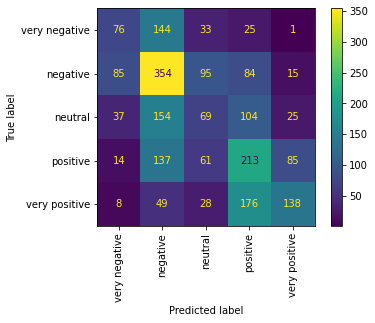

In [24]:
from sklearn.metrics import ConfusionMatrixDisplay

class_labels = ['very negative', 'negative', 'neutral', 'positive', 'very positive']
ConfusionMatrixDisplay.from_predictions(y_true, y_pred, display_labels=class_labels, xticks_rotation="vertical");

__YOUR ANSWER HERE__

**(A) :** The easiest class is `negative` label, about 0.6288% accuracy. The most difficult class is `neutral` label, about 0.1388 accuracy.
However, Accuracy is not a reliable index for measuring performance of the classifier, because it will give misleading results if the dataset is unbalanced (i.e. the number of negative classes is 633, so the result will observe negative mostly).

### Task 4. Fine-tuned embeddings (1 point)

Since we fine-tuned the pretrained word embeddings, they should now better fit our task, which is sentiment classification.

Try different words that have sentimental meaning, e.g. "bad", "good", "fantastic", "disgusting", and find similar words to them using both pretrained GloVe and fine-tuned embeddings. 

Briefly describe which words you tried and which difference you observed. Provide some examples.

In [25]:
def get_word_embedding(word, embeddings, vocab):
    return embeddings[vocab[word]]

def find_most_similar(word, embeddings, token2idx, idx2token, n=5):
    word_norm = torch.nn.functional.normalize(get_word_embedding(word, embeddings, token2idx), dim=0)
    emb_norm = torch.nn.functional.normalize(embeddings, dim=1)
    similarities = torch.matmul(word_norm, emb_norm.T)
    top_n = torch.argsort(similarities, descending=True)[1:n+1]
    
    print(f'Top-{n} most similar to the word "{word}":\n')
    for idx in top_n:
        print(f'{idx2token[idx]}\t{similarities[idx]:.4f}')

In [30]:
# Pretrained Glove embeddings
find_most_similar('nice', glove_vecs, token2idx, idx2token)

Top-5 most similar to the word "nice":

wonderful	0.5994
pretty	0.5976
guy	0.5972
good	0.5929
lovely	0.5860


In [31]:
# Fine-tuned embeddings
find_most_similar('nice', model.emb.weight, token2idx, idx2token)

Top-5 most similar to the word "nice":

lovely	0.5584
wonderful	0.5556
pretty	0.5423
fun	0.5111
'll	0.5096


__YOUR ANSWER HERE__

**(A) :** in sentimental meaning term, it can be easliy to replce and correct in grammatical fluency(e.g., `nice`, `better` ). But when I try `unsentimental` term (e.g., `king`, `dog`) both still have nearly same word but different score.